# Análisis avanzado de sentimiento con `Reviews.csv`

Versión mejorada del notebook de sentimiento para el dataset de reseñas de Amazon.

En este notebook añadimos:
- Más clasificadores
- Nuevas variables numéricas (longitud de reseña, métricas de `Helpfulness`)
- Transformaciones (logaritmos y normalización en variables numéricas)
- Más gráficas exploratorias
- Validación cruzada (cross-validation)


Extraemos el .csv de kaggle

https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews/data


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import ( accuracy_score, classification_report, confusion_matrix, roc_curve, auc)
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)


## Paso 1: Carga y exploración inicial del CSV  
Se lee **`Reviews.csv`** con `pandas` y se revisan las primeras filas (`head`), los tipos de datos (`info`) y algunas estadísticas básicas (`describe`). Esto permite comprobar que las columnas se han leído bien, detectar valores nulos y hacerse una idea de la escala y el tipo de cada variable.

## Paso 2: Análisis de la distribución de `Score`  
Se calcula cuántas reviews hay de cada puntuación (1, 2, 3, 4 y 5) y se representa en gráficos. Esto sirve para entender si el dataset está equilibrado (muchas opiniones positivas frente a negativas) y justificar cómo se definirá la etiqueta de sentimiento.

## Paso 3: Creación de la etiqueta de sentimiento  
Se define una nueva columna **`sentiment`** que vale `1` si `Score ≥ 4` y `0` en caso contrario. La idea es separar claramente las reviews satisfechas de las que no lo están tanto. Esta columna es la **variable objetivo (`y`)** que el modelo intentará aprender a predecir.

## Paso 4: Unir `Summary` y `Text` en una sola columna  
Para simplificar el trabajo con texto, se crea una columna **`full_text`** que concatena el título (`Summary`) y el cuerpo de la review (`Text`). Así el modelo ve toda la información textual relevante en un único campo, lo que suele mejorar la calidad de la señal de entrada.

## Paso 5: Crear variables numéricas adicionales  
Se generan *features* numéricas como la longitud de la review en caracteres y palabras, y variables relacionadas con la utilidad percibida (`help_num`, `help_den`, `help_ratio`). Estas variables aportan contexto adicional: por ejemplo, las reviews muy largas o muy votadas pueden ser especialmente relevantes para entender el sentimiento global.

## Paso 6: Dividir los datos en entrenamiento y test  
Se separan los datos en un conjunto de **entrenamiento (80%)** y otro de **test (20%)** con `train_test_split`. Se usa la opción `stratify=y` para que el porcentaje de reviews positivas y no positivas sea similar en ambos conjuntos. El modelo **aprende sólo con el train** y se evalúa en el test.

## Paso 7: Definir el preprocesado de texto y numéricas  
Para el texto se aplica **`TfidfVectorizer`**, que convierte las palabras en números en función de su frecuencia e importancia. Para las variables numéricas se construye un pequeño *pipeline* que primero **imputa valores faltantes**, luego aplica un **logaritmo** para suavizar escalas extremas y finalmente **estandariza** las variables (media 0, desviación 1). Todo esto se integra en un **`ColumnTransformer`**.

## Paso 8: Crear varios *pipelines* de modelos  
Se definen diferentes modelos de clasificación (Regresión Logística, SVM lineal, Random Forest, `SGDClassifier`, `PassiveAggressive`, etc.), cada uno envuelto en un **`Pipeline`** que incluye el preprocesado. De este modo, entrenar un modelo es tan sencillo como llamar a `fit()` sobre el pipeline y las transformaciones se aplican siempre de forma coherente.

## Paso 9: Entrenar y evaluar cada modelo  
Se lanza un bucle sobre todos los *pipelines*, entrenándolos con `X_train, y_train` y calculando sus predicciones sobre `X_test`. Para cada modelo se obtienen métricas como **accuracy, precision, recall y F1**, y se construye una **matriz de confusión** que muestra cuántas reviews se clasifican correctamente o incorrectamente.

## Paso 10: Comparar modelos y elegir el mejor  
Los resultados se almacenan en un DataFrame (`results_df`), donde cada fila corresponde a un modelo con sus métricas. Se ordena por `accuracy` y se identifica el mejor modelo. En algunos casos también se examinan métricas como **ROC AUC** o **PR AUC**, especialmente útiles si el problema está desbalanceado.

## Paso 11: Analizar la matriz de confusión del mejor modelo  
Para el modelo ganador se dibuja una matriz de confusión en forma de *heatmap*. Esto permite ver, de manera muy visual, cuántas reviews positivas y no positivas acierta y dónde se equivoca más. Es un paso clave para entender si el modelo tiende a ser demasiado optimista o demasiado conservador.

## Paso 12: Validación cruzada y robustez  
Mediante técnicas como **`StratifiedKFold`**, se repite el entrenamiento varias veces con distintas particiones del dataset. Así se obtiene una estimación más robusta de las métricas, comprobando que el rendimiento del modelo no depende de una única división train/test.

## 1. Carga del CSV

- Puedes leer el `.csv` directamente o el `.zip` si dentro solo hay un archivo.
- Ajusta la ruta a tu caso (por ejemplo, `C:/Users/Asus Vivobook/Downloads/Reviews.csv.zip`).

In [ ]:
#Uso la ruta ya que mi ordenador el nombre de admin tiene un " "
df = pd.read_csv(r"C:\Users\Asus Vivobook\Documents\APPS PYTHON\EDA\ML\REVIEWS AMAZON\Reviews.csv.zip")

df.head()



,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## 2. Exploración rápida de las columnas

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
df.describe(include='all').T #Cada fila es una variable

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,568454.0,NaN,NaN,NaN,284227.5,164098.679298,1.0,142114.25,284227.5,426340.75,568454.0
ProductId,568454,74258,B007JFMH8M,913,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UserId,568454,256059,A3OXHLG6DIBRW8,448,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProfileName,568428,218415,"C. F. Hill ""CFH""",451,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HelpfulnessNumerator,568454.0,NaN,NaN,NaN,1.743817,7.636513,0.0,0.0,0.0,2.0,866.0
HelpfulnessDenominator,568454.0,NaN,NaN,NaN,2.22881,8.28974,0.0,0.0,1.0,2.0,923.0
Score,568454.0,NaN,NaN,NaN,4.183199,1.310436,1.0,4.0,5.0,5.0,5.0
Time,568454.0,NaN,NaN,NaN,1296256604.90242,48043312.332416,939340800.0,1271289600.0,1311120000.0,1332720000.0,1351209600.0
Summary,568427,295742,Delicious!,2462,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Text,568454,393579,"This review will make me sound really stupid, ...",199,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Distribución de `Score` y balance de clases

Distribución de Score:
Score
1     52268
2     29769
3     42640
4     80655
5    363122
Name: count, dtype: int64


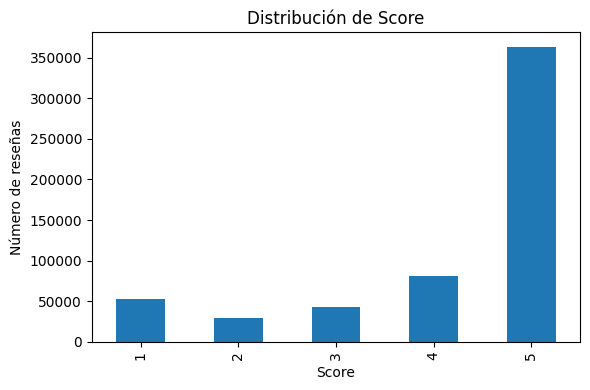

In [30]:
score_counts = df['Score'].value_counts().sort_index()
print('Distribución de Score:')
print(score_counts)

plt.figure(figsize=(6,4))
score_counts.plot(kind='bar')
plt.xlabel('Score')
plt.ylabel('Número de reseñas')
plt.title('Distribución de Score')
plt.tight_layout()
plt.show()

## 4. Crear etiqueta binaria de sentimiento

- Consideramos **positivo** si `Score ≥ 4`.
- Consideramos **no positivo** si `Score ≤ 3`.

Creamos una nueva columna `sentiment` (1 = positivo, 0 = no positivo).

Distribución de sentiment:
sentiment
1    443777
0    124677
Name: count, dtype: int64

Distribución relativa:
sentiment
1    0.780674
0    0.219326
Name: proportion, dtype: float64


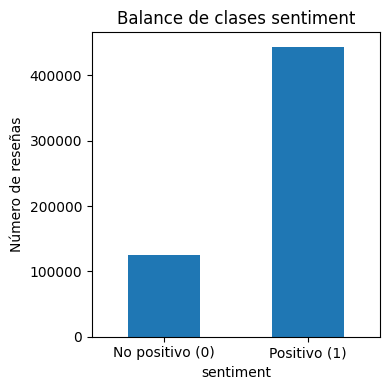

In [ ]:
df = df.dropna(subset=['Score'])

df['sentiment'] = (df['Score'] >= 4).astype(int)
print('Distribución de sentiment:')
print(df['sentiment'].value_counts())
print('\nDistribución relativa:')
print(df['sentiment'].value_counts(normalize=True))

plt.figure(figsize=(4,4))
df['sentiment'].value_counts().sort_index().plot(kind='bar')
plt.xticks([0,1], ['No positivo (0)', 'Positivo (1)'], rotation=0)
plt.ylabel('Número de reseñas')
plt.title('Balance de clases sentiment')
plt.tight_layout()
plt.show()

## 5. Unir `Summary` y `Text` en una sola columna de texto

Creamos una columna `full_text` que concatena `Summary` y `Text`.

In [32]:
df['Summary'] = df['Summary'].fillna('')
df['Text'] = df['Text'].fillna('')
df['full_text'] = (df['Summary'].astype(str) + ' ' + df['Text'].astype(str)).str.strip()
df[['Summary', 'Text', 'full_text']].head()

,Summary,Text,full_text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...,Good Quality Dog Food I have bought several of...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised Product arrived labeled as J...
2,"""Delight"" says it all",This is a confection that has been around a fe...,"""Delight"" says it all This is a confection tha..."
3,Cough Medicine,If you are looking for the secret ingredient i...,Cough Medicine If you are looking for the secr...
4,Great taffy,Great taffy at a great price. There was a wid...,Great taffy Great taffy at a great price. The...


## 6. Variables numéricas adicionales + logaritmos y normalización

Creamos algunas features numéricas:
- `review_len_chars`: longitud del texto en caracteres
- `review_len_words`: longitud en número de palabras
- `help_num`: `HelpfulnessNumerator`
- `help_den`: `HelpfulnessDenominator`
- `help_ratio`: `help_num / (help_den + 1)`

Después aplicaremos:
- `log1p` a las variables de helpfulness (para comprimir colas muy grandes)
- `StandardScaler` para normalizar las numéricas (media 0, desviación típica 1)

In [33]:
# Longitud de reseña
df['review_len_chars'] = df['full_text'].str.len()
df['review_len_words'] = df['full_text'].str.split().str.len()

# Métricas de helpfulness
df['help_num'] = df['HelpfulnessNumerator'].fillna(0)
df['help_den'] = df['HelpfulnessDenominator'].fillna(0)
df['help_ratio'] = df['help_num'] / (df['help_den'] + 1)

df[['review_len_chars', 'review_len_words', 'help_num', 'help_den', 'help_ratio']].describe()

,review_len_chars,review_len_words,help_num,help_den,help_ratio
count,568454.000000,568454.000000,568454.000000,568454.00000,568454.000000
mean,460.667780,84.377125,1.743817,2.22881,0.273433
std,449.843623,80.253687,7.636513,8.28974,0.317269
min,23.000000,4.000000,0.000000,0.00000,0.000000
25%,200.000000,37.000000,0.000000,0.00000,0.000000
50%,325.000000,60.000000,0.000000,1.00000,0.000000
75%,554.000000,102.000000,2.000000,2.00000,0.500000
max,21535.000000,3451.000000,866.000000,923.00000,1.500000


Estas variables describen cómo son las reseñas y qué tan “útiles” resultan para otros usuarios: `review_len_chars` y `review_len_words` indican la longitud del texto en caracteres y palabras, mostrando que la review típica es corta–media (medianas de 325 caracteres y 60 palabras), aunque existen unos pocos “tochos” enormes que disparan los máximos. `help_num` (votos útiles) y `help_den` (votos totales) revelan que la mayoría de reseñas casi no recibe interacción (medianas 0 y 1, respectivamente), mientras unas pocas acumulan cientos de votos y se vuelven muy influyentes. Por último, `help_ratio = help_num / (help_den + 1)` intenta medir la proporción de votos útiles, pero su distribución está muy sesgada (muchos 0, pocos valores altos e incluso algunos outliers por encima de 1), lo que indica que sólo una minoría de reviews concentra verdaderos “votos de utilidad” y que conviene revisar estos extremos antes de entrenar el modelo.


## 7. Gráficas exploratorias adicionales

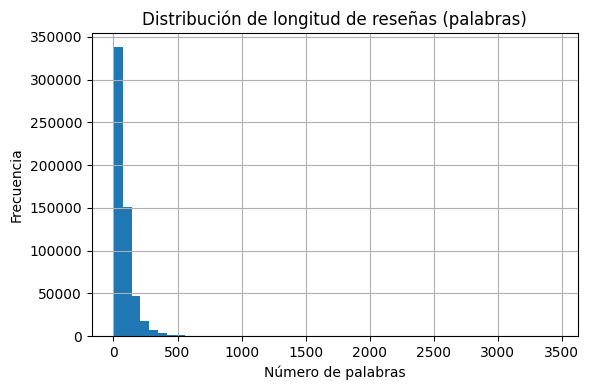

<Figure size 600x400 with 0 Axes>

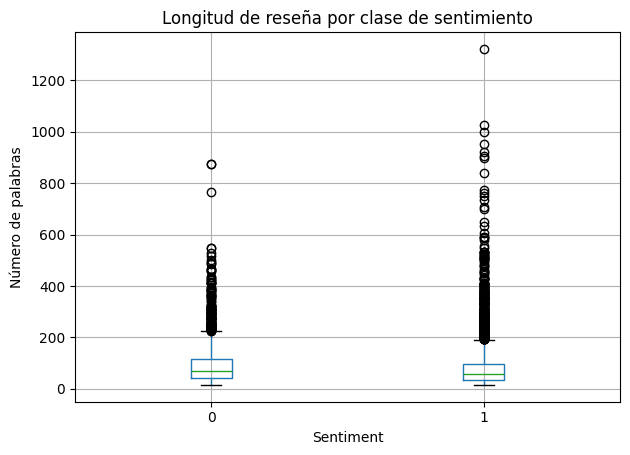

In [ ]:
plt.figure(figsize=(6,4))
df['review_len_words'].hist(bins=50)
plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')
plt.title('Distribución de longitud de reseñas (palabras)')
plt.tight_layout()
plt.show()

sample_plot = df.sample(n=min(10000, len(df)), random_state=42)
plt.figure(figsize=(6,4))
sample_plot.boxplot(column='review_len_words', by='sentiment')
plt.suptitle('')
plt.xlabel('Sentiment')
plt.ylabel('Número de palabras')
plt.title('Longitud de reseña por clase de sentimiento')
plt.tight_layout()
plt.show()

Tasa de reseñas positivas (sentiment=1) vs Score

In [ ]:
# sentiment=1 para  Score
pos_rate_by_score = df.groupby("Score")["sentiment"].mean().sort_index()
count_by_score    = df["Score"].value_counts().sort_index()

print("Tasa de reseñas positivas por Score:")
print(pos_rate_by_score)
print("\nNúmero de reseñas por Score:")
print(count_by_score)




Tasa de reseñas positivas por Score:
Score
1    0.0
2    0.0
3    0.0
4    1.0
5    1.0
Name: sentiment, dtype: float64

Número de reseñas por Score:
Score
1     52268
2     29769
3     42640
4     80655
5    363122
Name: count, dtype: int64


Boxplots: longitud de reseñas vs sentimiento / Score

In [ ]:
#
df.boxplot(column="review_len_words", by="sentiment", ax=axes[0])
axes[0].set_title("Longitud de reseñas vs sentiment (0 = no positivo, 1 = positivo)")
axes[0].set_xlabel("sentiment")
axes[0].set_ylabel("Nº de palabras")

# 
df.boxplot(column="review_len_words", by="Score", ax=axes[1])
axes[1].set_title("Longitud de reseñas vs Score (1–5)")
axes[1].set_xlabel("Score")
axes[1].set_ylabel("Nº de palabras")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

 Barras: tasa de reseñas positivas

In [ ]:
df_flags = df.copy()

median_len = df_flags["review_len_words"].median()
median_help_ratio = df_flags["help_ratio"].median()

df_flags["long_review"] = (df_flags["review_len_words"] >= median_len).astype(int)
df_flags["high_help_ratio"] = (df_flags["help_ratio"] >= median_help_ratio).astype(int)

flags_cols = ["long_review", "high_help_ratio"]
print("Flags disponibles:", flags_cols)

fig, axes = plt.subplots(len(flags_cols), 1, figsize=(8, 4 * len(flags_cols)))

if len(flags_cols) == 1:
    axes = [axes]

for ax, col in zip(axes, flags_cols):
    #sentiment=1 (positivo) dentro de cada valor del flag (0/1)
    rates = df_flags.groupby(col)["sentiment"].mean()

    rates.plot(kind="bar", ax=ax)

    ax.set_title(f"Tasa de reseñas positivas según {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Proporción sentiment = 1")


    ax.set_xticks(range(len(rates.index)))
    ax.set_xticklabels([str(v) for v in rates.index], rotation=0)

plt.tight_layout()
plt.show()

Mapa de calor de correlaciones

Flags disponibles: ['long_review', 'high_help_ratio']


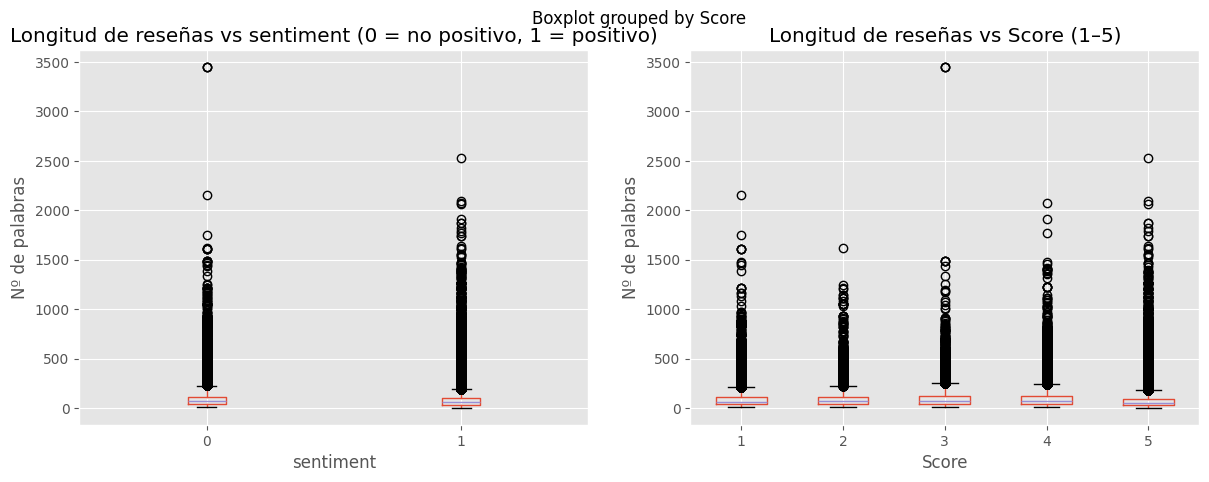

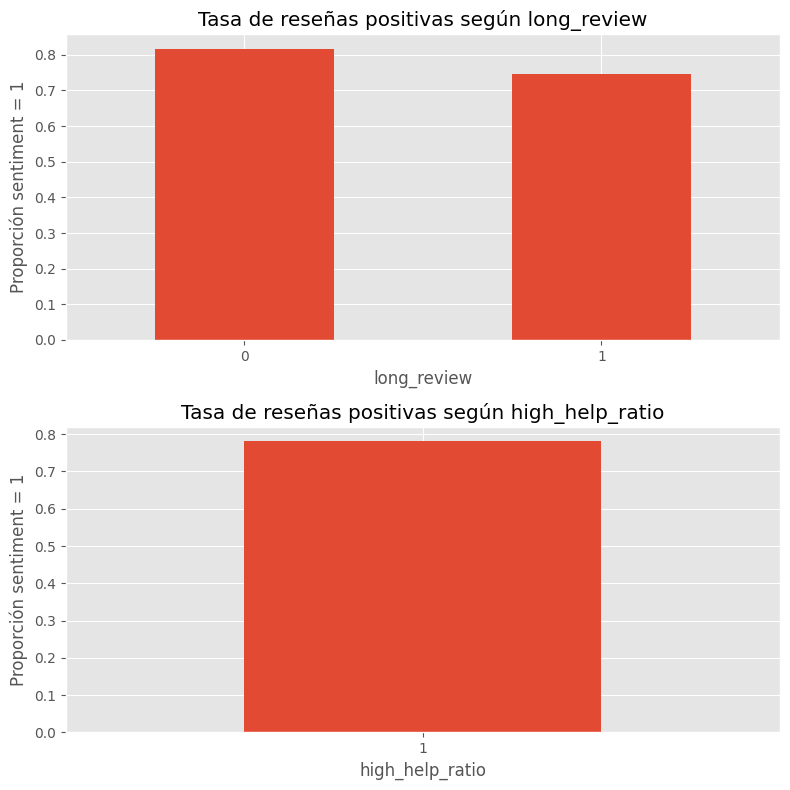

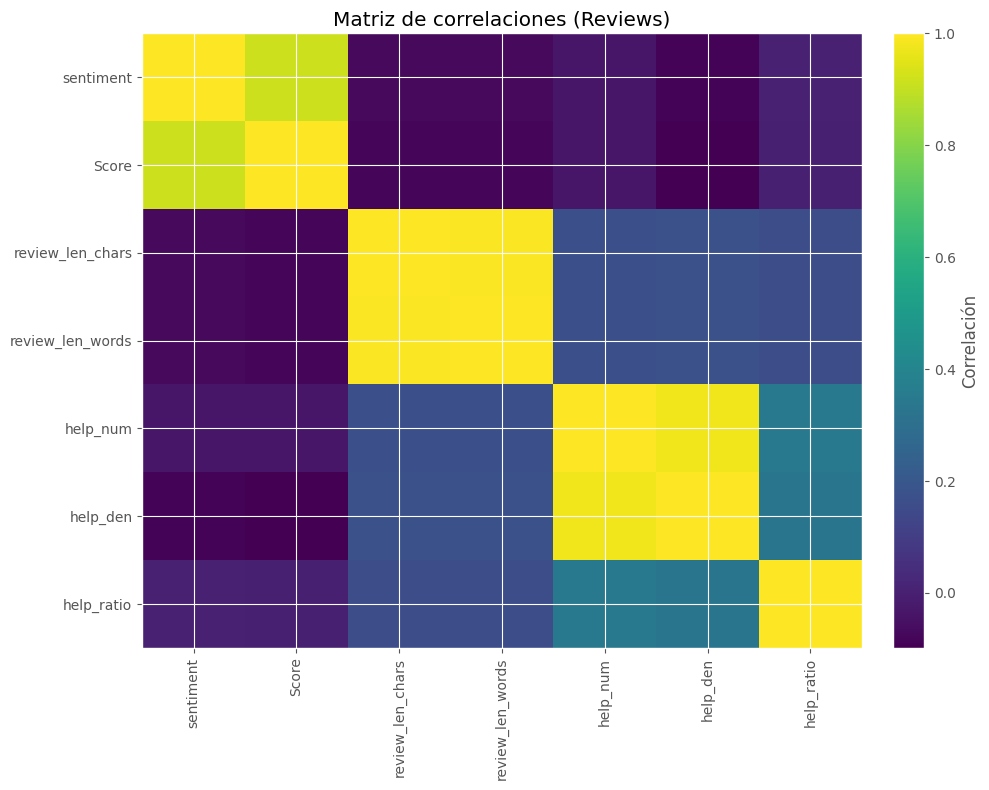

In [ ]:
# Usamos variables numéricas relevantes + la etiqueta
cols_corr = ["sentiment", "Score"] + features_num
cols_corr = [c for c in cols_corr if c in df.columns]

corr_matrix = df[cols_corr].corr()

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr_matrix, aspect="auto")

ax.set_xticks(range(len(cols_corr)))
ax.set_xticklabels(cols_corr, rotation=90)
ax.set_yticks(range(len(cols_corr)))
ax.set_yticklabels(cols_corr)
ax.set_title("Matriz de correlaciones (Reviews)")

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Correlación", rotation=90)

plt.tight_layout()
plt.show()

Media de help_ratio vs Score

Media de help_ratio por Score:
Score
1    0.307190
2    0.256389
3    0.242242
4    0.247915
5    0.279302
Name: help_ratio, dtype: float64

Número de reseñas por Score:
Score
1     52268
2     29769
3     42640
4     80655
5    363122
Name: count, dtype: int64


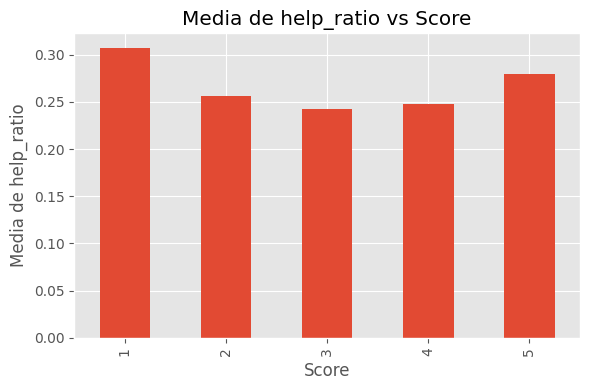

In [ ]:
help_mean_by_score = df.groupby("Score")["help_ratio"].mean().sort_index() #Segun la nota que dan, ¿cómo cambia la ‘utilidad’ (help_ratio)
count_by_score     = df["Score"].value_counts().sort_index()

print("Media de help_ratio por Score:")
print(help_mean_by_score)
print("\nNúmero de reseñas por Score:")
print(count_by_score)

plt.figure(figsize=(6,4))
help_mean_by_score.plot(kind="bar")
plt.xlabel("Score")
plt.ylabel("Media de help_ratio")
plt.title("Media de help_ratio vs Score")
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(6,4))
df.boxplot(column="help_ratio", by="Score")
plt.title("Distribución de help_ratio por Score")
plt.suptitle("") 
plt.xlabel("Score")
plt.ylabel("help_ratio")
plt.tight_layout()
plt.show()


## 8. División en train/test

In [ ]:
features_text = ['full_text']
features_num = ['review_len_chars', 'review_len_words', 'help_num', 'help_den', 'help_ratio']

X = df[features_text + features_num]
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_test.shape

((454763, 6), (113691, 6))

## 9. Preprocesado: texto (TF-IDF) + numéricas (log + normalización)

- Para texto usamos `TfidfVectorizer`.
- Para numéricas usamos un pipeline:
  - `SimpleImputer` (por si hay nulos)
  - `FunctionTransformer(np.log1p)` para aplicar `log(1+x)`
  - `StandardScaler` para normalizar.

In [ ]:
text_transformer = TfidfVectorizer(max_features=20000, ngram_range=(1,2), stop_words='english')

num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),('log', FunctionTransformer(np.log1p, validate=False)), ('scaler', StandardScaler())])

preprocess = ColumnTransformer(
    transformers=[('text', text_transformer, 'full_text'),('num', num_transformer, features_num)])


## 10. Definir varios modelos de clasificación

Probamos:
- Regresión logística
- SVM lineal (`LinearSVC`)
- RandomForest
- `SGDClassifier` (clasificador lineal entrenado con descenso de gradiente)
- `PassiveAggressiveClassifier`


In [ ]:
pipelines = {
    'LogisticRegression': Pipeline([
        ('preprocess', preprocess),
        ('clf', LogisticRegression(max_iter=1000))]),

    'LinearSVC': Pipeline([
        ('preprocess', preprocess),
        ('clf', LinearSVC()) ]),

    'RandomForest': Pipeline([
        ('preprocess', preprocess),
        ('clf', RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            n_jobs=-1,
            random_state=42))]),

    'SGDClassifier': Pipeline([
        ('preprocess', preprocess),
        ('clf', SGDClassifier(loss='log_loss', max_iter=1000, n_jobs=-1, random_state=42))]),

    'PassiveAggressive': Pipeline([
        ('preprocess', preprocess),
        ('clf', PassiveAggressiveClassifier(max_iter=1000, random_state=42))])}

pipelines

{'LogisticRegression': Pipeline(steps=[('preprocess',
                  ColumnTransformer(transformers=[('text',
                                                   TfidfVectorizer(max_features=20000,
                                                                   ngram_range=(1,
                                                                                2),
                                                                   stop_words='english'),
                                                   'full_text'),
                                                  ('num',
                                                   Pipeline(steps=[('imputer',
                                                                    SimpleImputer(strategy='median')),
                                                                   ('log',
                                                                    FunctionTransformer(func=<ufunc 'log1p'>)),
                                                   

LogisticRegression
Se usa porque es un modelo lineal muy estable, rápido y fácil de interpretar: aprende pesos para cada palabra/feature y devuelve una probabilidad de que la reseña sea positiva; suele funcionar muy bien con texto vectorizado (TF-IDF) y permite entender qué términos empujan hacia positivo o negativo.

LinearSVC
Es un SVM lineal pensado justo para datos de texto con muchas columnas (miles de palabras); busca la “mejor frontera” para separar positivas y no positivas y suele dar un rendimiento muy alto en clasificación de texto, siendo rápido de entrenar incluso con muchos ejemplos y features.

RandomForest
Es un conjunto de muchos árboles de decisión, útil para capturar relaciones más complejas y no lineales entre variables (incluyendo las numéricas); se incluye para comparar un enfoque “basado en árboles” frente a los modelos lineales y ver si aporta mejora o no en este problema.

SGDClassifier
Usa descenso de gradiente estocástico, lo que lo hace muy eficiente para datasets grandes: es básicamente un modelo lineal (tipo regresión logística o SVM) entrenado de forma incremental, así que sirve para probar una alternativa rápida y escalable sobre las mismas features de texto.

PassiveAggressiveClassifier
Es un modelo lineal pensado para flujos de datos: solo se ajusta cuando se equivoca (passive–aggressive), por lo que es útil si en un futuro quisieras ir actualizando el modelo “sobre la marcha” con nuevas reseñas sin reentrenar todo desde cero.

## 11. Entrenar y evaluar modelos

In [38]:
results = {}
for name, pipe in pipelines.items():
    print(f"\n\n######## {name} ########")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy en test: {acc:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, digits=3))
    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de confusión:\n", cm)
    results[name] = {'accuracy': acc, 'confusion_matrix': cm, 'model': pipe}

results



######## LogisticRegression ########
Accuracy en test: 0.9258

Classification report:
              precision    recall  f1-score   support

           0      0.875     0.772     0.820     24935
           1      0.938     0.969     0.953     88756

    accuracy                          0.926    113691
   macro avg      0.906     0.871     0.887    113691
weighted avg      0.924     0.926     0.924    113691

Matriz de confusión:
 [[19261  5674]
 [ 2759 85997]]


######## LinearSVC ########
Accuracy en test: 0.9293

Classification report:
              precision    recall  f1-score   support

           0      0.866     0.802     0.833     24935
           1      0.946     0.965     0.955     88756

    accuracy                          0.929    113691
   macro avg      0.906     0.884     0.894    113691
weighted avg      0.928     0.929     0.928    113691

Matriz de confusión:
 [[20000  4935]
 [ 3101 85655]]


######## RandomForest ########
Accuracy en test: 0.9271

Classification

{'LogisticRegression': {'accuracy': 0.9258252632134469,
  'confusion_matrix': array([[19261,  5674],
         [ 2759, 85997]]),
  'model': Pipeline(steps=[('preprocess',
                   ColumnTransformer(transformers=[('text',
                                                    TfidfVectorizer(max_features=20000,
                                                                    ngram_range=(1,
                                                                                 2),
                                                                    stop_words='english'),
                                                    'full_text'),
                                                   ('num',
                                                    Pipeline(steps=[('imputer',
                                                                     SimpleImputer(strategy='median')),
                                                                    ('log',
                                     

## 12. Comparar `accuracy` de los modelos

LinearSVC             0.929317
RandomForest          0.927092
LogisticRegression    0.925825
PassiveAggressive     0.918780
SGDClassifier         0.876200
dtype: float64


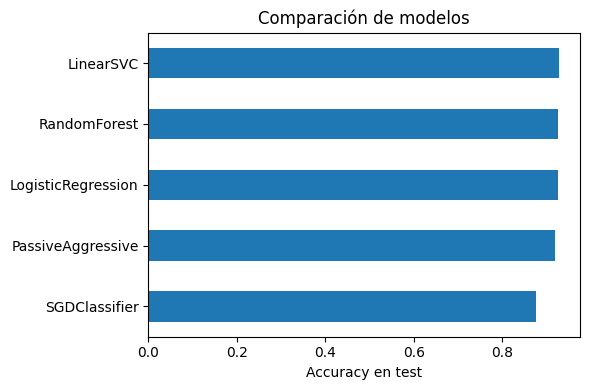

In [39]:
acc_series = pd.Series({k: v['accuracy'] for k, v in results.items()})
print(acc_series.sort_values(ascending=False))
plt.figure(figsize=(6,4))
acc_series.sort_values().plot(kind='barh')
plt.xlabel('Accuracy en test')
plt.title('Comparación de modelos')
plt.tight_layout()
plt.show()

## 13. Matriz de confusión del mejor modelo

Mejor modelo por accuracy: LinearSVC
Matriz de confusión:
 [[20000  4935]
 [ 3101 85655]]


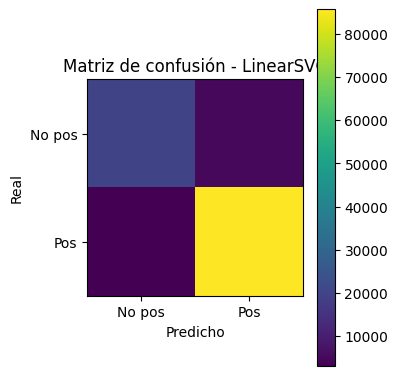

In [ ]:
best_model_name = max(results, key=lambda k: results[k]['accuracy']) #selecionamos el mejor modelo LinearSVC
best_cm = results[best_model_name]['confusion_matrix']
print('Mejor modelo por accuracy:', best_model_name)
print('Matriz de confusión:\n', best_cm)

plt.figure(figsize=(4,4))
plt.imshow(best_cm, interpolation='nearest')
plt.title(f'Matriz de confusión - {best_model_name}')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['No pos', 'Pos'])
plt.yticks(tick_marks, ['No pos', 'Pos'])
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.tight_layout()
plt.show()

## 14. Curva ROC y AUC (por ejemplo, Regresión Logística)

AUC: 0.9647


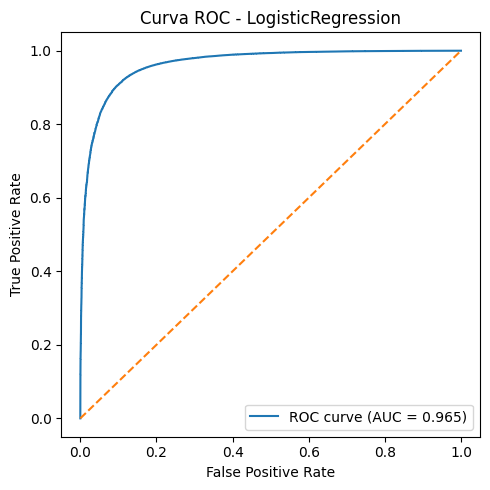

In [41]:
logit_model = results['LogisticRegression']['model']
if hasattr(logit_model, 'predict_proba'):
    y_proba = logit_model.predict_proba(X_test)[:, 1]
else:
    # Fallback: usar decision_function si no hay predict_proba
    y_proba = logit_model.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - LogisticRegression')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## 15. Validación cruzada (cross-validation)

La validación cruzada nos da una estimación más robusta del rendimiento.
Para que no tarde demasiado, podemos usar una muestra del dataset.

In [ ]:
# Subsample para CV,ajusta n según la potencia de tu máquina
df_cv = df.sample(n=min(50000, len(df)), random_state=42)
X_cv = df_cv[features_text + features_num]
y_cv = df_cv['sentiment']

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
pipe_cv = pipelines['LogisticRegression']  

cv_scores = cross_val_score(pipe_cv, X_cv, y_cv, cv=cv, scoring='accuracy', n_jobs=-1)
print('CV scores:', cv_scores)
print('Media accuracy CV:', cv_scores.mean())
print('Desviación típica:', cv_scores.std())

CV scores: [0.90376192 0.899982   0.89727589]
Media accuracy CV: 0.9003399387190463
Desviación típica: 0.0026599809867641974


## 16. Guardar el mejor modelo entrenado

Será el que importaremos a StreamLit

In [43]:
import joblib

best_model_name = max(results, key=lambda k: results[k]['accuracy'])
best_model = results[best_model_name]['model']
joblib.dump(best_model, f'modelo_sentiment_avanzado_{best_model_name}.pkl')
print(f'Modelo guardado: modelo_sentiment_avanzado_{best_model_name}.pkl')

Modelo guardado: modelo_sentiment_avanzado_LinearSVC.pkl


PassiveAggressiveClassifier no está en pipelines, se omite.


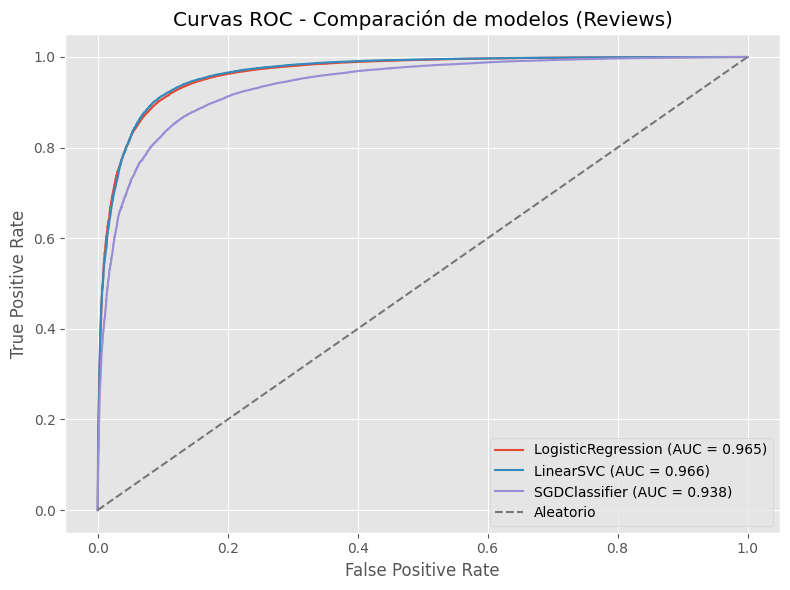

Mejor modelo para PR curve: LinearSVC


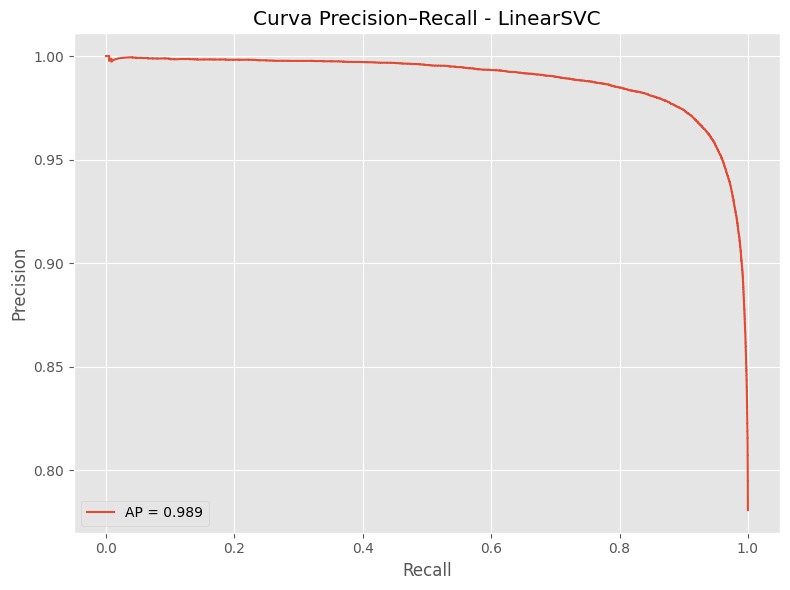

In [76]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score
)

plt.style.use("ggplot")  # estilo algo más "bonito"




# ============================================================
# 5) Curvas ROC comparando modelos
# ============================================================

models_to_plot = ["LogisticRegression", "LinearSVC" ,"SGDClassifier", "PassiveAggressiveClassifier"]
# Puedes añadir más si quieres: 'PassiveAggressive', etc.

fig, ax = plt.subplots(figsize=(8, 6))

for name in models_to_plot:
    if name not in pipelines:
        print(f"{name} no está en pipelines, se omite.")
        continue

    pipe = pipelines[name]
    pipe.fit(X_train, y_train)

    # Intentamos sacar puntuaciones tipo probabilidad
    if hasattr(pipe, "predict_proba"):
        y_proba = pipe.predict_proba(X_test)[:, 1]
    elif hasattr(pipe, "decision_function"):
        y_proba = pipe.decision_function(X_test)
    else:
        print(f"{name} no soporta predict_proba ni decision_function, se omite en ROC.")
        continue

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

ax.plot([0, 1], [0, 1], linestyle="--", label="Aleatorio")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Curvas ROC - Comparación de modelos (Reviews)")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()


# ============================================================
# 6) Curva Precision–Recall del mejor modelo
# ============================================================

# Usamos el diccionario 'results' que creaste al evaluar los modelos
best_model_name = max(results, key=lambda k: results[k]['accuracy'])
print("Mejor modelo para PR curve:", best_model_name)

best_pipe = results[best_model_name]["model"]

if hasattr(best_pipe, "predict_proba"):
    y_scores = best_pipe.predict_proba(X_test)[:, 1]
elif hasattr(best_pipe, "decision_function"):
    y_scores = best_pipe.decision_function(X_test)
else:
    raise ValueError(
        "El mejor modelo no tiene ni predict_proba ni decision_function."
    )

precision, recall, _ = precision_recall_curve(y_test, y_scores)
avg_prec = average_precision_score(y_test, y_scores)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(recall, precision, label=f"AP = {avg_prec:.3f}")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title(f"Curva Precision–Recall - {best_model_name}")
ax.legend(loc="lower left")
plt.tight_layout()
plt.show()


La gráfica ROC sirve para comparar cómo de bien distintos modelos distinguen reseñas positivas de negativas para *todos* los posibles umbrales de decisión: en el eje X está el porcentaje de negativas mal clasificadas como positivas (False Positive Rate) y en el eje Y el porcentaje de positivas bien detectadas (True Positive Rate), mientras que la línea diagonal gris representa un modelo aleatorio sin capacidad real de discriminación. En tu caso, las curvas de LogisticRegression (AUC ≈ 0.965) y LinearSVC (AUC ≈ 0.966) se acercan mucho a la esquina superior izquierda, lo que indica que identifican muy bien las reseñas positivas sin generar demasiados falsos positivos, mientras que SGDClassifier (AUC ≈ 0.938) funciona algo peor pero sigue siendo claramente mejor que el azar. Técnicamente, se calculan estos puntos variando el umbral, se dibuja la curva ROC y se resume su calidad con el área bajo la curva (AUC), lo que justifica que LogisticRegression y LinearSVC sean buenas candidatas para usar en producción.

El gráfico muestra que las opiniones más extremas, especialmente las de 1 estrella y en menor medida las de 5, tienen de media un `help_ratio` más alto, es decir, reciben proporcionalmente más votos de “esta reseña me ha sido útil” que las valoraciones intermedias. En cambio, las reseñas de 2, 3 y 4 estrellas presentan ratios de utilidad más bajos, lo que sugiere que los usuarios tienden a considerar más útiles las opiniones muy negativas (porque ayudan a evitar un mal producto) y también las muy positivas (porque refuerzan que algo merece la pena), mientras que las reseñas “tibias” pasan más desapercibidas y generan menos interacción relativa.



Palabras más importantes según un modelo lineal + counts

In [ ]:
model_name = "LogisticRegression"

pipe = pipelines[model_name]
pipe.fit(X_train, y_train) #trainpipe

Recuperar el vectorizador de texto (TF-IDF)

Ahora vemos qué palabras empujan a positivo y a negativo, y con qué fuerza. Primero se recupera del Pipeline el transformador de texto (text_vectorizer) dentro del preprocess para obtener el listado de features de texto (feature_names_text: las palabras y n-gramas que creó el TfidfVectorizer). Luego se extrae el clasificador (clf) y sus coeficientes (clf.coef_): en un modelo lineal, cada feature tiene un peso; si ese peso es positivo, la palabra empuja hacia reseña positiva, si es negativo, hacia reseña negativa, y cuanto más grande en valor absoluto, más importante es. Como en el ColumnTransformer el bloque de texto va primero, las primeras posiciones de coefs corresponden justo a esas palabras, por eso se corta con coefs[:n_text_features]. Después, se calcula cuántas reviews de entrenamiento contienen cada palabra (doc_counts) aplicando el vectorizador de texto sobre X_train["full_text"] y contando en cuántos documentos aparece cada término. Finalmente, se ordenan las palabras por coeficiente: las de coeficientes más altos son las más asociadas a reseñas positivas, las de coeficientes más bajos a negativas, y se imprimen junto con count_docs para saber si son patrones frecuentes o solo palabras raras que salen en muy pocas reviews. En conjunto, todo esto sirve para explicar con ejemplos concretos qué ha aprendido el modelo a nivel de vocabulario.

In [ ]:

#dentro del ColumnTransformer 'preprocess' con nombre 'text'
preprocess = pipe.named_steps["preprocess"]
text_vectorizer = preprocess.named_transformers_["text"]

# (palabras / n-gramas)
feature_names_text = np.array(text_vectorizer.get_feature_names_out())

# 2) Recuperar el clasificador lineal
clf = pipe.named_steps["clf"]

if not hasattr(clf, "coef_"):
    raise ValueError(
        f"El modelo {model_name} no tiene atributo coef_, "
        "prueba con otro (p.ej. LogisticRegression o SGDClassifier)."
    )

# Para binario, coef_ tiene forma (1, n_features_totales)
coefs = clf.coef_[0]

# En el ColumnTransformer, el bloque de texto ('text') va primero,
# así que las primeras len(feature_names_text) posiciones de coefs son palabras
n_text_features = len(feature_names_text)
coefs_text = coefs[:n_text_features]

# === Cálculo de counts (nº de reseñas donde aparece cada palabra) ===
# Usamos sólo el texto de X_train para que cuadre con el modelo
X_text_train = text_vectorizer.transform(X_train["full_text"])
# nº de documentos (reviews) donde la palabra aparece al menos una vez
doc_counts = np.asarray((X_text_train > 0).sum(axis=0)).ravel()

# 3) Seleccionar top palabras positivas y negativas
top_n = 30  # número de palabras que quieres ver

# Índices ordenados por coeficiente
top_pos_idx = np.argsort(coefs_text)[-top_n:]   # más grandes (positivas)
top_neg_idx = np.argsort(coefs_text)[:top_n]    # más pequeñas (negativas)

print(f"\nPalabras más asociadas a reseñas POSITIVAS ({model_name}) \n")
for idx in reversed(top_pos_idx):
    word = feature_names_text[idx]
    coef = coefs_text[idx]
    count = doc_counts[idx]  # nº de reviews de train donde aparece
    print(f"{word:<25}  coef = {coef: .4f}   count_docs = {int(count)}")

print(f"\nPalabras más asociadas a reseñas NEGATIVAS ({model_name}) \n")
for idx in top_neg_idx:
    word = feature_names_text[idx]
    coef = coefs_text[idx]
    count = doc_counts[idx]
    print(f"{word:<25}  coef = {coef: .4f}   count_docs = {int(count)}")



========= Palabras más asociadas a reseñas POSITIVAS (LogisticRegression) =========

great                      coef =  13.5529   count_docs = 140230
best                       coef =  12.8599   count_docs = 69530
delicious                  coef =  12.3935   count_docs = 40426
excellent                  coef =  11.8218   count_docs = 25251
perfect                    coef =  10.5819   count_docs = 27098
yum                        coef =  10.3248   count_docs = 7039
yummy                      coef =  9.2020   count_docs = 15231
awesome                    coef =  8.9244   count_docs = 11920
loves                      coef =  8.8822   count_docs = 29602
amazing                    coef =  8.6653   count_docs = 12290
wonderful                  coef =  8.6316   count_docs = 21589
love                       coef =  8.5988   count_docs = 96739
hooked                     coef =  8.1295   count_docs = 4038
just right                 coef =  7.6141   count_docs = 7205
won disappointed           c

El análisis de `coef` y `count_docs` de la LogisticRegression permite ver qué palabras empujan una review hacia positiva (coef > 0) o negativa (coef < 0) y, además, cuán frecuentes son en el conjunto de opiniones. El modelo captura que las reseñas positivas se apoyan en términos como *great, best, delicious, excellent, amazing, highly recommend, favorite*, que reflejan calidad, placer y recomendación fuerte, y que aparecen en muchas reviews, por lo que son verdaderos “drivers” de satisfacción. En cambio, las reseñas negativas están dominadas por palabras como *disappointing, worst, terrible, disgusting, rip-off, waste money, stale, bland, tasteless*, que expresan decepción, mala calidad/sabor y sensación de tirar el dinero, e incluso términos como “ok/okay” se comportan como señal de tibieza. Esto hace que el modelo sea muy interpretable: no es una caja negra, sino una forma de ver con claridad qué lenguaje y temas concretos empujan la satisfacción hacia arriba o hacia abajo.


Doc count plots: 20 palabras más repetidas (positivas y negativas)

Usamos las palabras más características de reseñas positivas y negativas según tu modelo: primero creas un DataFrame con cada palabra, su coeficiente (coef, que indica si empuja hacia positivo o negativo) y en cuántas reviews aparece (count_docs); luego, para las positivas, te quedas solo con las palabras cuyos coeficientes son más altos (top_pos_idx), ordenas esas por count_docs y pintas las 20 que aparecen en más reseñas, mostrando así cuáles son los términos “positivos” más repetidos; para las negativas haces lo mismo pero con los coeficientes más bajos (top_neg_idx), obteniendo las 20 palabras “negativas” más frecuentes. En resumen: los dos gráficos te enseñan qué vocabulario usa el modelo para reconocer opiniones muy buenas y muy malas, y además cuán extendido está ese lenguaje en tu conjunto de entrenamiento.

In [ ]:
words_df = pd.DataFrame({"word": feature_names_text,"coef": coefs_text, "count_docs": doc_counts})

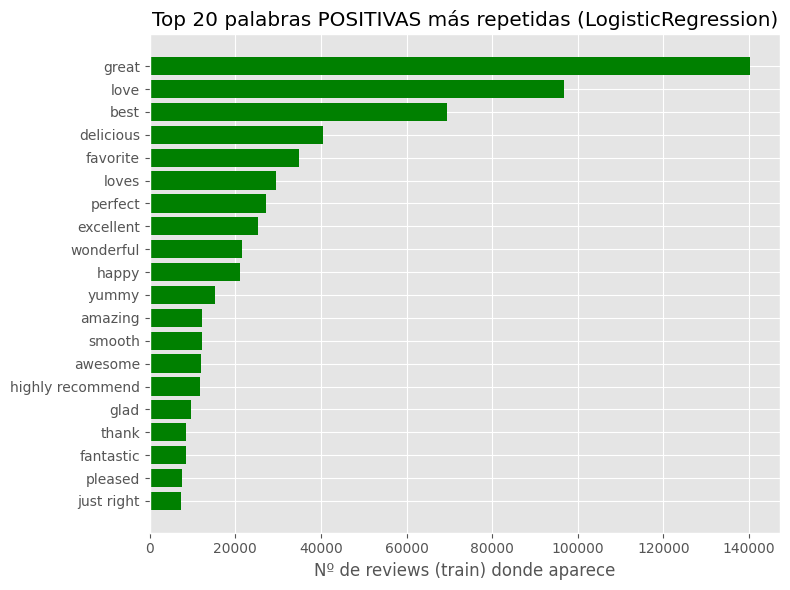

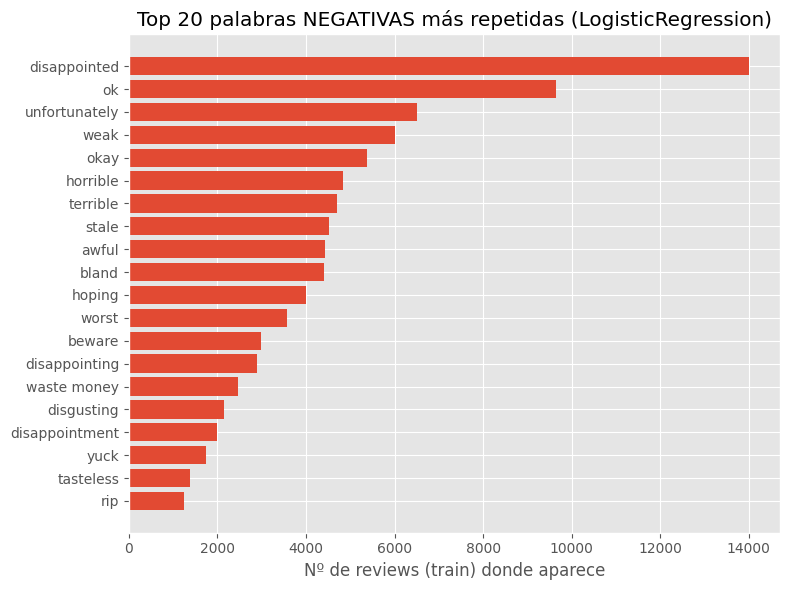

In [ ]:

# Positivas: usamos solo las palabras de top_pos_idx 
pos_df = words_df.iloc[top_pos_idx].copy()


top20_pos = pos_df.sort_values("count_docs", ascending=False).head(20)

plt.figure(figsize=(8, 6))
top20_pos_sorted = top20_pos.sort_values("count_docs")  # para que salgan ordenadas en el barh
plt.barh(top20_pos_sorted["word"], top20_pos_sorted["count_docs"], color= "green")
plt.xlabel("Nº de reviews (train) donde aparece")
plt.title(f"Top 20 palabras POSITIVAS más repetidas ({model_name})")
plt.tight_layout()
plt.show()

# Negativas: usamos solo las palabras de top_neg_idx 
neg_df = words_df.iloc[top_neg_idx].copy()

top20_neg = neg_df.sort_values("count_docs", ascending=False).head(20)

plt.figure(figsize=(8, 6))
top20_neg_sorted = top20_neg.sort_values("count_docs")
plt.barh(top20_neg_sorted["word"], top20_neg_sorted["count_docs"])
plt.xlabel("Nº de reviews (train) donde aparece")
plt.title(f"Top 20 palabras NEGATIVAS más repetidas ({model_name})")
plt.tight_layout()
plt.show()


In [ ]:
words_df = pd.DataFrame({
    "word": feature_names_text,
    "coef": coefs_text,
    "count_docs": doc_counts

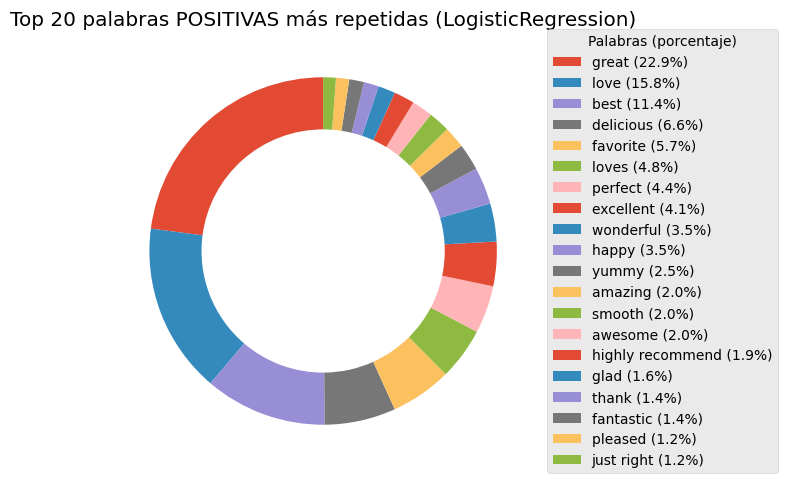

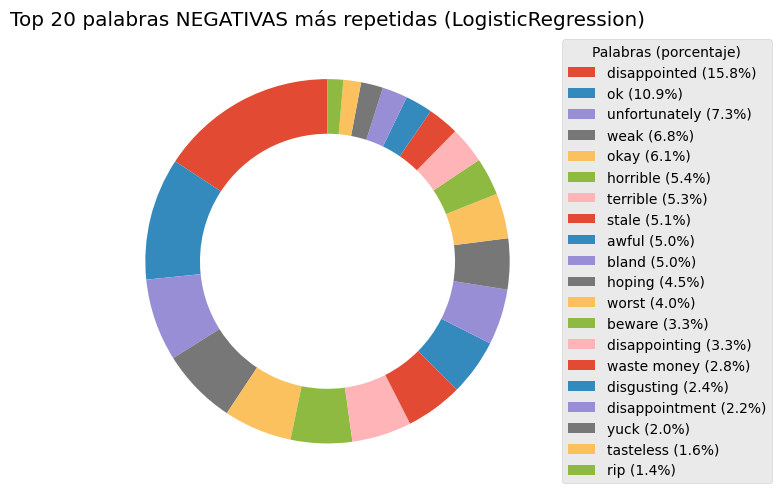

In [ ]:
#POSITIVAS 
pos_df = words_df.iloc[top_pos_idx].copy()
top20_pos = pos_df.sort_values("count_docs", ascending=False).head(20)

fig, ax = plt.subplots(figsize=(7, 7))

sizes_pos = top20_pos["count_docs"].values
labels_pos = top20_pos["word"].values


total_pos = sizes_pos.sum()
pct_pos = (sizes_pos / total_pos) * 100


legend_labels_pos = [
    f"{w} ({p:.1f}%)" for w, p in zip(labels_pos, pct_pos)
]

wedges, texts = ax.pie(
    sizes_pos,
    startangle=90,
    wedgeprops=dict(width=0.3)  # donut
)

ax.set_aspect("equal")
ax.set_title(f"Top 20 palabras POSITIVAS más repetidas ({model_name})")

ax.legend(
    wedges,
    legend_labels_pos,
    title="Palabras (porcentaje)",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.tight_layout()
plt.show()

# NEGATIVAS 
neg_df = words_df.iloc[top_neg_idx].copy()
top20_neg = neg_df.sort_values("count_docs", ascending=False).head(20)

fig, ax = plt.subplots(figsize=(7, 7))

sizes_neg = top20_neg["count_docs"].values
labels_neg = top20_neg["word"].values

total_neg = sizes_neg.sum()
pct_neg = (sizes_neg / total_neg) * 100

legend_labels_neg = [
    f"{w} ({p:.1f}%)" for w, p in zip(labels_neg, pct_neg)
]

wedges, texts = ax.pie(
    sizes_neg,
    startangle=90,
    wedgeprops=dict(width=0.3)
)

ax.set_aspect("equal")
ax.set_title(f"Top 20 palabras NEGATIVAS más repetidas ({model_name})")

ax.legend(
    wedges,
    legend_labels_neg,
    title="Palabras (porcentaje)",
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)

plt.tight_layout()
plt.show()


Los resultados muestran que todos los modelos lineales funcionan muy bien sobre las reseñas de texto, con una accuracy alrededor del 92–93%, F1 cercano a 0.95, ROC AUC en torno a 0.96 y PR AUC casi 0.99, lo que indica que distinguen de forma muy fiable entre opiniones positivas y negativas; entre ellos, LinearSVC destaca como el mejor compromiso, superando ligeramente a LogisticRegression en todas las métricas y manteniendo tiempos de entrenamiento muy razonables (del orden de decenas de segundos), mientras que SGDClassifier queda por detrás y RandomForest se descarta por coste y ajuste, por lo que elegimos LinearSVC como modelo final tanto por su rendimiento como por su facilidad de reentrenar en un entorno real.


Grafico de accuracy en test por modelo (colores + centésimas)

Normalizamos el `accuracy` en `acc_norm = (acc_vals - acc_min) / (acc_max - acc_min + 1e-9)`  para poder usarlo como entrada del *colormap* (`plt.cm.viridis`), que espera valores entre 0 y 1: el peor modelo (accuracy mínimo) queda con color “bajo” del mapa, el mejor (accuracy máximo) con el color “alto”, y el resto se reparte proporcionalmente entre medias, de forma que el color de cada barra refleja visualmente lo buena que es frente a las otras; el `+ 1e-9` es solo para evitar una división por cero en el caso extremo de que todos los modelos tuviesen exactamente el mismo accuracy.


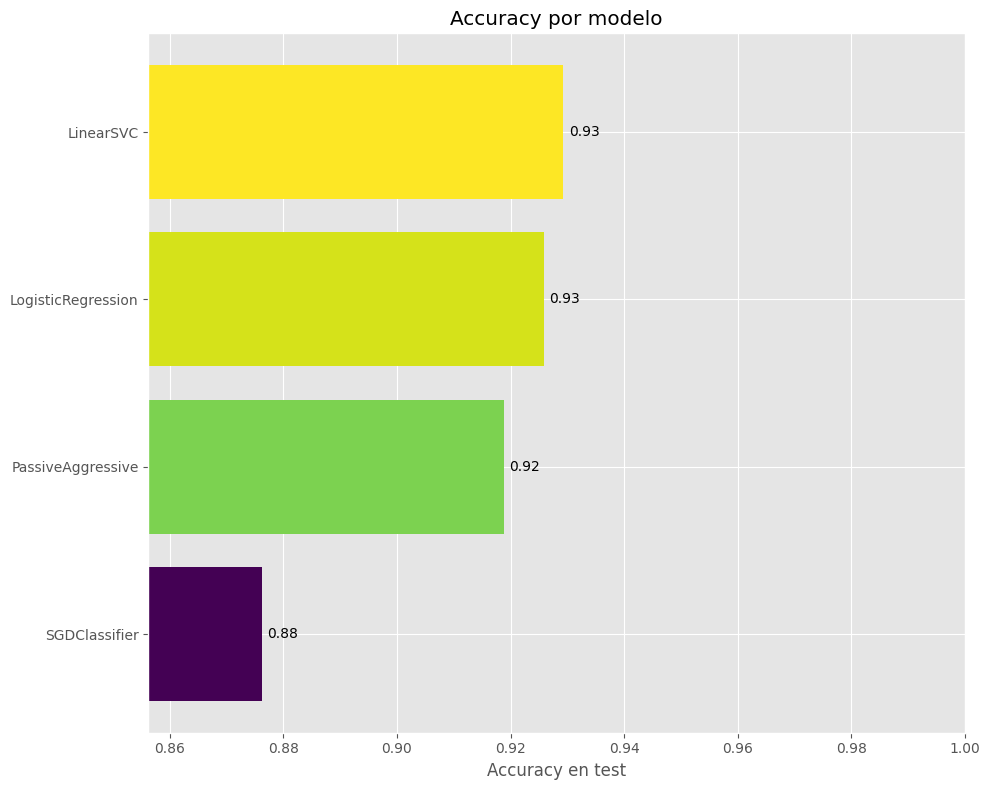

In [ ]:
plt.figure(figsize=(10, 8))

plot_df = results_df.dropna(subset=["accuracy"]).copy()
plot_df = plot_df.sort_values("accuracy", ascending=True)

# Normalizamos el accuracy para mapearlo a un colormap
acc_vals = plot_df["accuracy"].values
acc_min, acc_max = acc_vals.min(), acc_vals.max()
acc_norm = (acc_vals - acc_min) / (acc_max - acc_min + 1e-9)


colors = plt.cm.viridis(acc_norm)

bars = plt.barh(plot_df["model"], plot_df["accuracy"], color=colors)

plt.xlabel("Accuracy en test")
plt.title("Accuracy por modelo")

for bar, acc in zip(bars, acc_vals):
    width = bar.get_width()
    plt.text(width + 0.001,                            bar.get_y() + bar.get_height() / 2,f"{acc:.2f}",                           va="center")

plt.xlim(acc_min - 0.02, 1.0) 
plt.tight_layout()
plt.show()



Gráfico de ROC AUC por modelo 

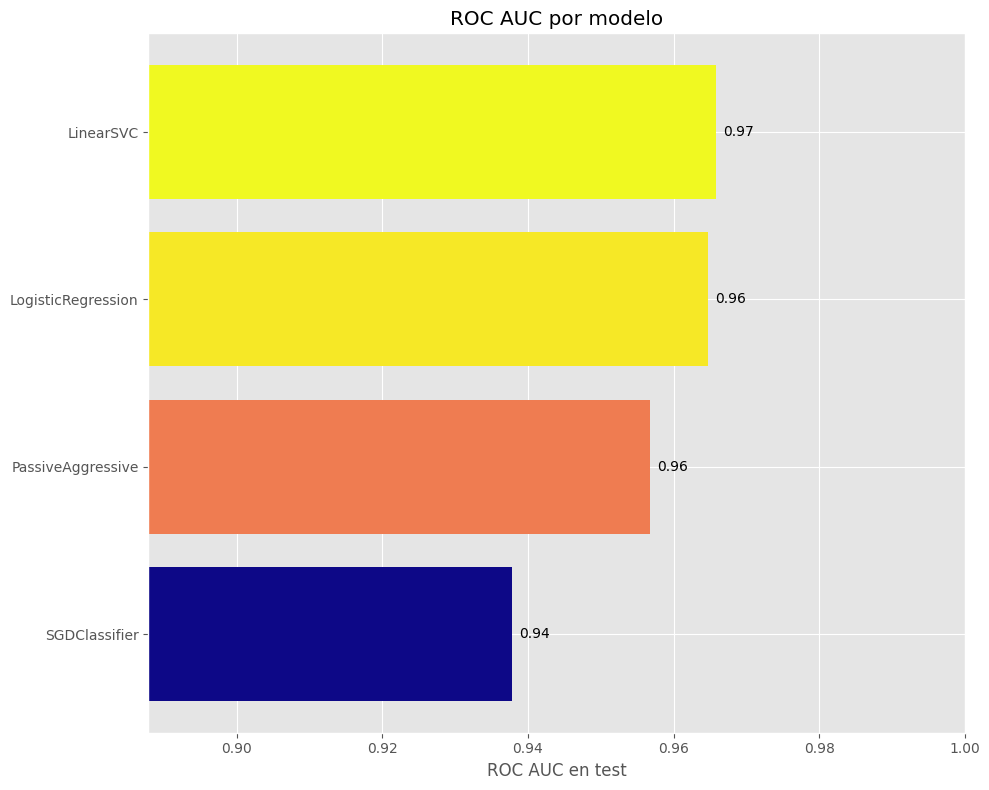

In [ ]:
plt.figure(figsize=(10, 8))
plot_auc = results_df.dropna(subset=["roc_auc"]).copy()
plot_auc = plot_auc.sort_values("roc_auc", ascending=True)

roc_vals = plot_auc["roc_auc"].values
roc_min, roc_max = roc_vals.min(), roc_vals.max()
roc_norm = (roc_vals - roc_min) / (roc_max - roc_min + 1e-9)


colors = plt.cm.plasma(roc_norm) 

bars = plt.barh(plot_auc["model"], plot_auc["roc_auc"], color=colors)

plt.xlabel("ROC AUC en test")
plt.title("ROC AUC por modelo")

for bar, auc_val in zip(bars, roc_vals):
    width = bar.get_width()
    plt.text(width + 0.001,bar.get_y() + bar.get_height() / 2, f"{auc_val:.2f}", va="center")

plt.xlim(max(0.0, roc_min - 0.05), 1.0)
plt.tight_layout()
plt.show()


Matriz de confusión del mejor modelo según accuracy

Mejor modelo según accuracy: LinearSVC


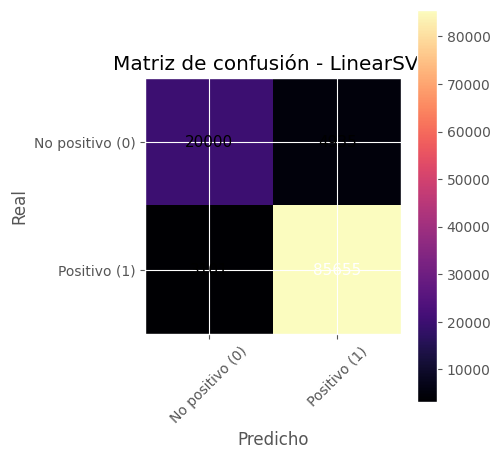

In [ ]:
best_row = results_df.iloc[0]
best_model_name = best_row["model"]
print("Mejor modelo según accuracy:", best_model_name)

best_pipe = pipelines[best_model_name]
y_pred_best = best_pipe.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(5, 5))

plt.imshow(cm, interpolation="nearest", cmap="magma")
plt.title(f"Matriz de confusión - {best_model_name}")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["No positivo (0)", "Positivo (1)"], rotation=45)
plt.yticks(tick_marks, ["No positivo (0)", "Positivo (1)"])
plt.ylabel("Real")
plt.xlabel("Predicho")


plt.tight_layout()
plt.show()


Construi  un sistema de ML que toma cada reseña (texto + variables numéricas) y aprende a predecir si es **positiva (1)** o **no positiva (0)** a partir de una etiqueta binaria derivada del `Score` (≥4 = 1, resto = 0). El texto (`Summary` + `Text`) se transforma en números con TF-IDF (palabras y bigramas más representativos) y lo complementas con features numéricas como longitud de la reseña, votos de “helpfulness” y su ratio, que luego imputas, transformas (log) y escalas. Todo eso se combina con un `ColumnTransformer` para generar una gran matriz de variables que alimenta distintos clasificadores (LinearSVC, LogisticRegression, SGD, Naive Bayes, RandomForest, etc.), que aprenden qué patrones de palabras y métricas explican mejor el sentimiento. Tras entrenar y evaluar los modelos en train/test, comparas métricas (accuracy, F1, ROC AUC, PR AUC) y analizas los coeficientes e importancias para entender qué lenguaje y qué factores cuantitativos empujan una reseña hacia positiva o negativa, eligiendo al final el modelo que mejor equilibrio ofrece entre rendimiento e interpretabilidad.

El proyecto demuestra que el modelo clasifica las reseñas en positivas / no positivas con alrededor de un 93% de acierto y métricas muy sólidas (F1 y AUC altas), por lo que es fiable para uso real. Además, el análisis de coeficientes revela que el lenguaje positivo se articula en torno a calidad y recomendación (“great”, “delicious”, “highly recommend”), mientras que el negativo gira en torno a decepción, mala calidad y sensación de tirar el dinero (“disappointing”, “worst”, “waste money”). Las reviews largas y detalladas, que concentran más votos de utilidad, son especialmente influyentes y las variables de “helpfulness” y longitud están muy correlacionadas entre sí; también se observa alta correlación entre sentiment y Score, lo que invita a no duplicar información y a simplificar las features para evitar colinealidad.

### ***AÑADIR GBOOST?

XGBoost es un modelo de **árboles potenciados (gradient boosting)**, es decir, un montón de árboles de decisión pequeños que se van corrigiendo unos a otros para minimizar el error; se usa porque suele ser **muy potente en problemas tabulares**, capturando relaciones no lineales y combinaciones raras entre variables numéricas (por ejemplo, longitudes, ratios, votos de utilidad…) mejor que un modelo lineal. En tu sistema lo puedes meter igual que los demás dentro de un `Pipeline` (`('preprocess', preprocess), ('clf', XGBClassifier(...))`): el `preprocess` vectoriza el texto y trata las variables numéricas, y XGBoost se encarga luego de aprender reglas del estilo “si la review es muy larga, habla de ‘disappointing’ y tiene cierto patrón de votos, probablemente es no positiva”. En texto puro con TF-IDF de muy alta dimensión a veces no gana a LinearSVC/logística, pero es interesante probarlo cuando tienes bastantes **features numéricas** y quieres capturar efectos más complejos.


In [ ]:
# Sumamos en la pipeline

    'XGBoost': Pipeline([
        ('preprocess', preprocess),
        ('clf', XGBClassifier(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='binary:logistic',
            eval_metric='logloss',
            n_jobs=-1,
            random_state=42,
            tree_method='hist' ))])}

#Tarda mucho tiempo, más que el forest, al mser una versión mejorada de este

GBoost es un modelo de árboles de decisión potenciados (gradient boosting) muy potente para capturar relaciones no lineales y combinaciones complejas entre variables numéricas; en tu caso sirve para explotar mejor las features de longitud, votos de utilidad, ratios, etc., sobre la misma representación vectorizada de texto. Lo usamos en un Pipeline igual que el resto: primero preprocess (TF-IDF + transformación numérica) y luego el clasificador XGBClassifier, de forma que puedas compararlo directamente con LinearSVC, LogisticRegression, RandomForest, etc.

Sería recomendable usar **XGBoost** porque es un modelo muy potente para datos “tabulares” y numéricos: puede capturar relaciones **no lineales** y combinaciones complejas entre variables (por ejemplo, longitud de la review, votos de utilidad, ratios, fecha, tipo de producto…) mucho mejor que un modelo lineal como LogisticRegression o LinearSVC. En tu sistema, donde ya tienes texto vectorizado + bastantes features numéricas, XGBoost puede aprovechar esas variables extra para encontrar reglas del tipo “reviews largas + muchas menciones a cierto término + patrón de votos de utilidad = muy negativas” sin que tú tengas que diseñar esas interacciones a mano, y sirve como **comparación fuerte** frente a los modelos lineales: si no mejora, confirmas que el lineal es suficiente; si sí mejora, tienes un candidato más potente para producción.


STREAMLIT

In [ ]:
https://thebridgepr-ctica-em8w4j9rnq73lykqvkekjs.streamlit.app/

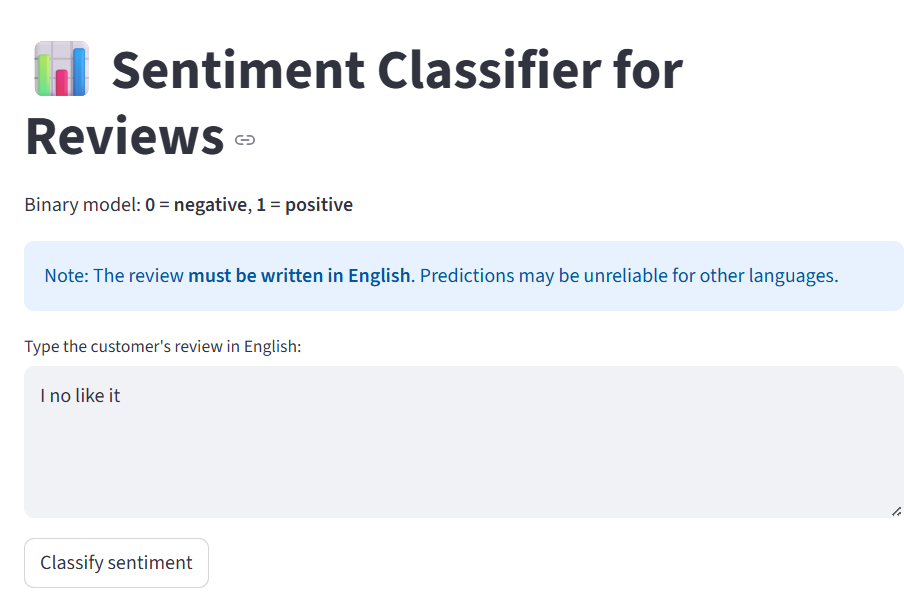